# Проект - Выбор локации для скважины
- **Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.**
- Шаги для выбора локации обычно такие:
    - В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
    - Строят модель для предсказания объёма запасов в новых скважинах;
    - Выбирают скважины с самыми высокими оценками значений;
    - Определяют регион с максимальной суммарной прибылью отобранных скважин.
- Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.
### Описание данных
- Данные геологоразведки трёх регионов:
- geo_data_0
- geo_data_1
- geo_data_2
- `id` — уникальный идентификатор скважины;
- `f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `roduct` — объём запасов в скважине (тыс. баррелей).
#### Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.
<a id='start'></a>

In [1]:
#загружаем нужные для работы библиотеки
import pandas as pd
import numpy as np
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format

## 1.  Загрузка и подготовка данных

In [2]:
#путь на серверр
server_0 = '/datasets/geo_data_0.csv'
server_1 = '/datasets/geo_data_1.csv'
server_2 = '/datasets/geo_data_2.csv'
#локальный путь
local_0 = 'geo_data_0.csv'
local_1 = 'geo_data_1.csv'
local_2 = 'geo_data_2.csv'
#не получится с сервера, загрузи с локального
try:
    geo_0 = pd.read_csv(server_0)
    geo_1 = pd.read_csv(server_1)
    geo_2 = pd.read_csv(server_2)
except: 
    geo_0 = pd.read_csv(local_0)
    geo_1 = pd.read_csv(local_1)
    geo_2 = pd.read_csv(local_2)

In [3]:
#знакомимся с таблицами: описательная статистика, дубликаты, пропуски
data,name = (geo_0,geo_1,geo_2),('geo_0', 'geo_1', 'geo_2')

for x, y in zip(data,name):
    display(y,x.head())
    print(x.describe())
    print()
    print('Дубликатов в таблице:',x.duplicated().sum())
    print('Пропусков в таблице:','\n',x.isna().sum())

'geo_0'

,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


             f0        f1        f2   product
count 100000.00 100000.00 100000.00 100000.00
mean       0.50      0.25      2.50     92.50
std        0.87      0.50      3.25     44.29
min       -1.41     -0.85    -12.09      0.00
25%       -0.07     -0.20      0.29     56.50
50%        0.50      0.25      2.52     91.85
75%        1.07      0.70      4.72    128.56
max        2.36      1.34     16.00    185.36

Дубликатов в таблице: 0
Пропусков в таблице: 
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


'geo_1'

,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77


             f0        f1        f2   product
count 100000.00 100000.00 100000.00 100000.00
mean       1.14     -4.80      2.49     68.83
std        8.97      5.12      1.70     45.94
min      -31.61    -26.36     -0.02      0.00
25%       -6.30     -8.27      1.00     26.95
50%        1.15     -4.81      2.01     57.09
75%        8.62     -1.33      4.00    107.81
max       29.42     18.73      5.02    137.95

Дубликатов в таблице: 0
Пропусков в таблице: 
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


'geo_2'

,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


             f0        f1        f2   product
count 100000.00 100000.00 100000.00 100000.00
mean       0.00     -0.00      2.50     95.00
std        1.73      1.73      3.47     44.75
min       -8.76     -7.08    -11.97      0.00
25%       -1.16     -1.17      0.13     59.45
50%        0.01     -0.01      2.48     94.93
75%        1.16      1.16      4.86    130.60
max        7.24      7.84     16.74    190.03

Дубликатов в таблице: 0
Пропусков в таблице: 
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [4]:
#функция, которая покажет нам распределение признаков
def distribution(table,name):
    for col in table[['f0','f1','f2','product',]]:
        print(f'Таблица {name}, признак: {col}')
        sns.displot(table, x=col)
        plt.show(f'Таблица {name}, признак: {col}')

Таблица geo_0, признак: f0


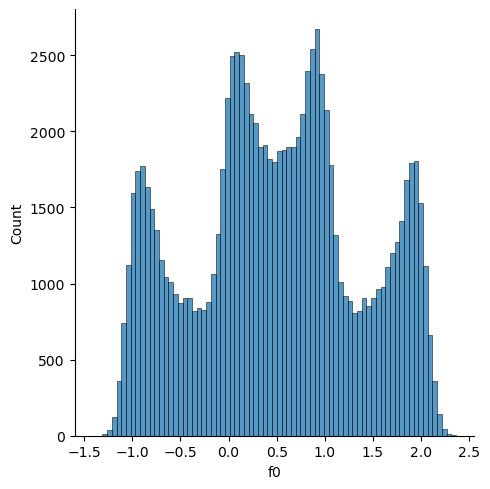

Таблица geo_0, признак: f1


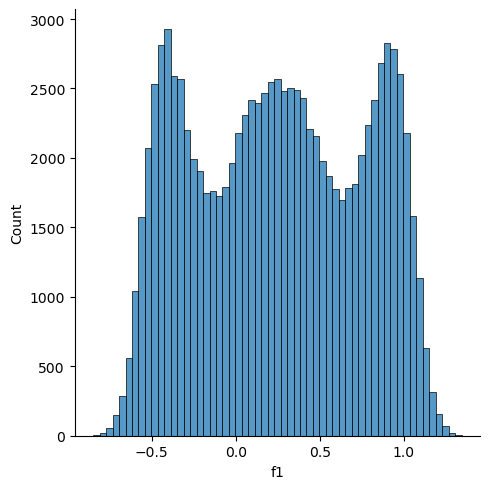

Таблица geo_0, признак: f2


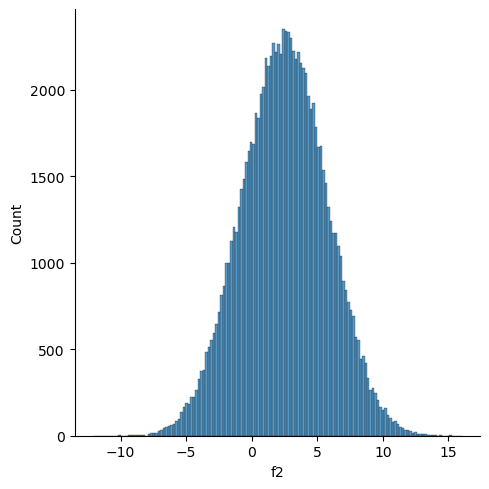

Таблица geo_0, признак: product


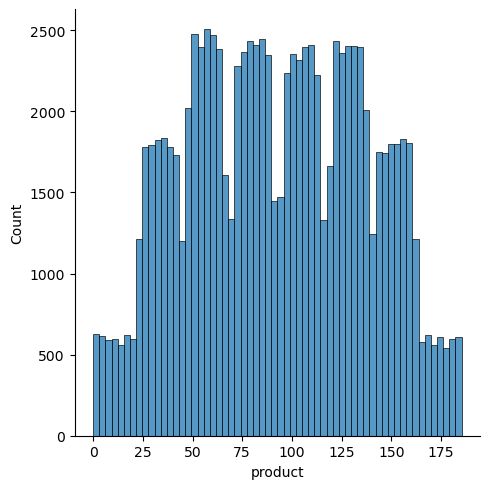

In [5]:
#смотрим распределение признаков
distribution(geo_0,'geo_0')

- У признака f2 распределение нормальное, у других с несколькими пиками

Таблица geo_1, признак: f0


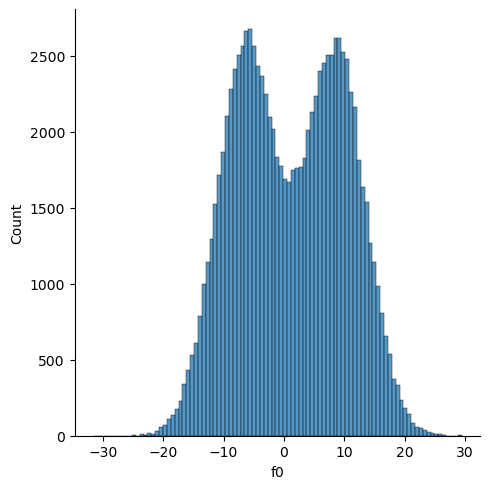

Таблица geo_1, признак: f1


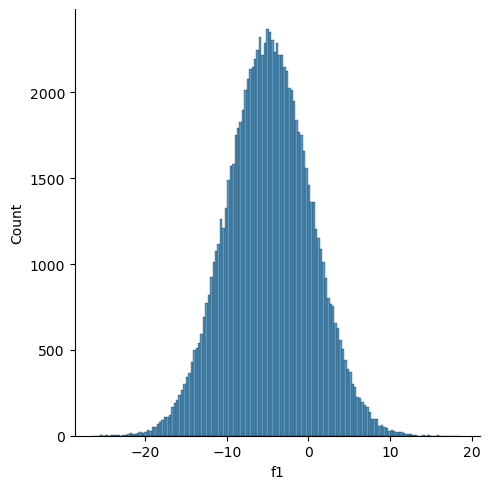

Таблица geo_1, признак: f2


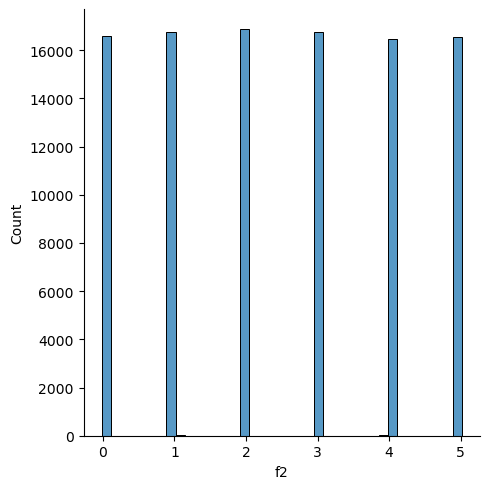

Таблица geo_1, признак: product


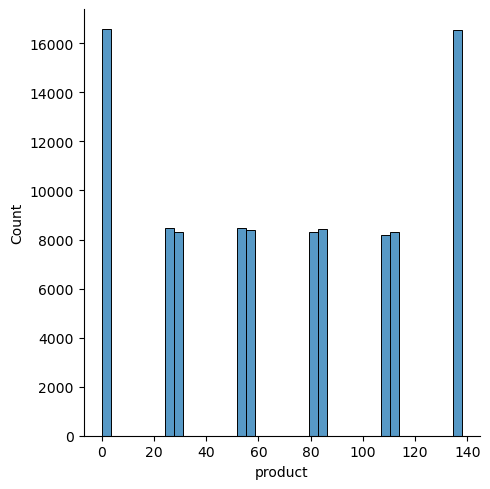

In [6]:
#смотрим распределение признаков
distribution(geo_1,'geo_1')

In [7]:
#среднее столбцов в geo_1: product и f2 
geo_1['product'].mean(),geo_1['f2'].mean()

(68.82500000002561, 2.494541252382829)

- У признаков: f0, f1 в таблице geo_1 распределение нормальное, а вот у признаков f2 и product похоже на биноминальное распределение, все значения как бы 'центрированы', то есть мы как будто анализировали скважины и например 16.тыс раз нашли там 0 баррелей нефти, или нашли 16 тыс раз 140 баррелей, не похоже на естественное распределение

Таблица geo_2, признак: f0


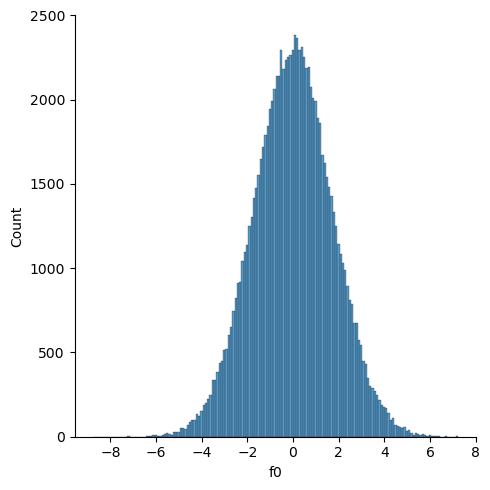

Таблица geo_2, признак: f1


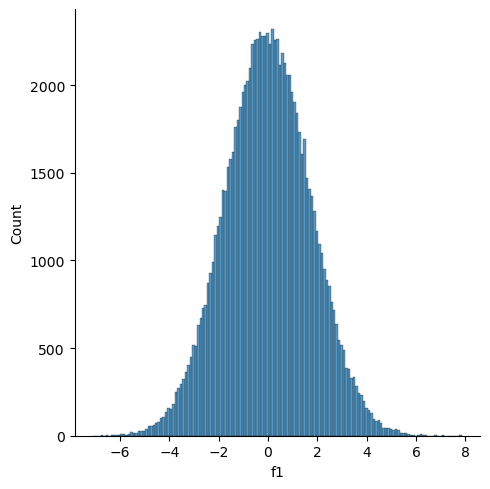

Таблица geo_2, признак: f2


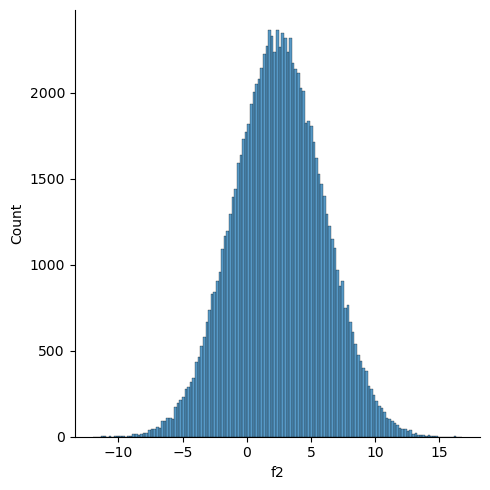

Таблица geo_2, признак: product


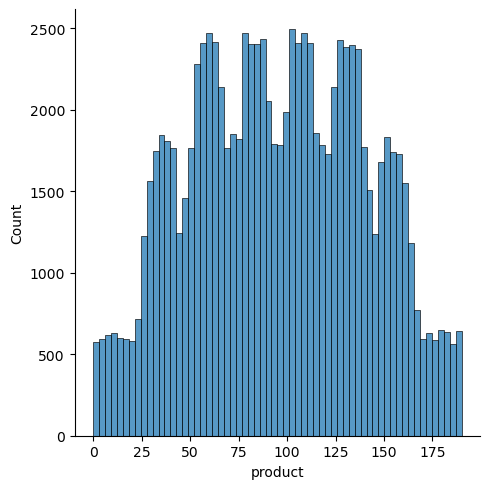

In [8]:
#смотрим распределение признаков geo_2
distribution(geo_2,'geo_2')

- Можно сказать что распределения признаков нормальные, в таблице geo_2 - распределение с несколькими пиками

In [9]:
#проверяем названия столбцов
for x, y in zip(data,name):
    print(y,':',x.columns)
    print()

geo_0 : Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')

geo_1 : Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')

geo_2 : Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')



In [10]:
#смотрим типы данных у таблиц
for x, y in zip(data,name):
    print('Таблица:',y)
    print(x.dtypes)
    print()

Таблица: geo_0
id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object

Таблица: geo_1
id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object

Таблица: geo_2
id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object



**Вывод:**
- Мы познакомились с таблицами: 
  - изучили распределения признаков - распределения нормальные, кроме таблицы geo_1 столбцов f1,f2,product  
  - проверили названия столбцов - все в хорошем стиле, без отступов, 
  - посмотрели типы данных у таблиц, 
  - узучили описательную статистику,
  - проверили пропуски и дубликаты - коих не обнаружено.

# 2. Обучение и проверка модели
<a id='study'></a>

- Создадим 2 таблицы: pred_answers-предсказания модели, target_answers-правильные ответы
- Создадим словарь, где ключом будет название локации, а значениями будут:
1. Предсказанное среднее
2. Среднее целевого признака
3. Корень из средней квадратичной ошибки то есть rmse
- Переменная `x` принимает на себя названия таблиц `y` названия локаций, далее мы формируем признаки - удаляем целевой признак(product) и id скважины, формируем целевой признак, разделяем данный в соотношении 75:25(тестовая), создаем модель, указываем параметр чтобы при вычислении использовала все доступные мощности для вычислений, обучаем модель, делаем предсказание, в словаре создаем ключ с названием региона и значениями(пункты 1,2,3)
- В pred_answers для каждой таблицы добавляем предсказание, target_answers добавляем правильный ответ

In [11]:
pred = {}
pred_answers = pd.DataFrame()
target_answers = pd.DataFrame()

for x, y in zip(data,name):
    features = x.drop(['product','id'],axis=1)
    target = x['product']
    
    X_train, X_valid, y_train,y_valid  = train_test_split(features, target,test_size=0.25, random_state=1)
    model = LinearRegression(n_jobs = -1)
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    
    pred[y] = (predictions.mean(),
               x['product'].mean(),
               mean_squared_error(y_valid, predictions)**0.5
              )
    target_answers[y] = y_valid
    pred_answers[y] = predictions

In [12]:
#проверяем
pred

{'geo_0': (92.49262459838863, 92.49999999999974, 37.74258669996437),
 'geo_1': (69.12040524285558, 68.82500000002561, 0.8943375629130574),
 'geo_2': (94.9568304858529, 95.00000000000041, 39.86671127773423)}

In [13]:
#проверяем
pred_answers

,geo_0,geo_1,geo_2
0,122.08,81.76,97.21
1,59.96,-0.09,73.69
2,103.77,54.76,89.23
3,75.19,108.37,59.60
4,117.37,54.40,149.77
...,...,...,...
24995,68.83,27.75,125.40
24996,88.22,138.04,80.50
24997,27.72,0.48,78.75
24998,78.84,84.34,91.34


In [14]:
#проверяем
target_answers

,geo_0,geo_1,geo_2
43660,89.93,80.86,102.73
87278,94.20,0.00,72.41
14317,123.55,53.91,27.08
81932,83.17,107.81,53.21
95321,146.29,53.91,112.65
...,...,...,...
54026,33.90,26.95,79.89
79431,58.02,137.95,54.94
2227,54.53,0.00,56.66
43025,133.32,84.04,152.31


In [15]:
#создадим таблицу для удобства
score = pd.DataFrame(data=pred, index = ['pred_mean','target_mean','rmse'])

In [16]:
#проверим
score

,geo_0,geo_1,geo_2
pred_mean,92.49,69.12,94.96
target_mean,92.50,68.83,95.00
rmse,37.74,0.89,39.87


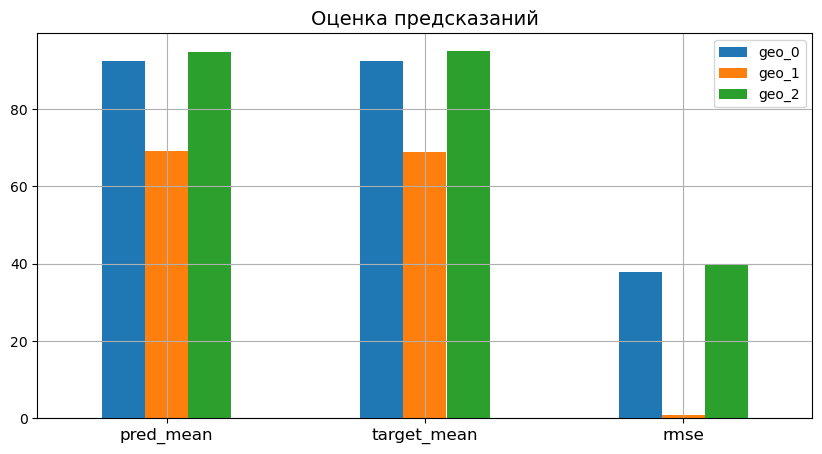

In [17]:
#построим график
score.plot(kind='bar', grid=True, figsize=(10, 5))
plt.title('Оценка предсказаний',fontsize=14)
plt.xticks(fontsize=12, rotation=0)
plt.show();

**Вывод**
<a id='error'></a>
- Мы обучили модель и сделали предсказания.
- Из результатов видно, что выгодными регионами для разработки являются регионы geo_0 и geo_2, т.к средний запас в них больше и наша модель тоже видит в этих регионах запас больше
- Однако, можно сказать, что посмотрите на ошибку по каждому региону в geo_0 и geo_2 она ошибается примерно на 40тыс. баррелей, а в geo_1 ошибка равна нулю. То есть по условию задачи в geo_0 и geo_2 мы можем недосчитаться 40тыс.баррелей $×$ 450р/баррель = 18.000.000 млн.р
- Но нсли мы вспомним распределение целевого признака(биноминальное распределение), все значения которого центрированы, что ставит под сомнение ествественную природу полученнных данных, из за не естественного распределения я не стану советовать данный регион для разработки, можно попробовать пресобрать данные если есть возможность, если нет то скорее всего лучше отказаться от данного региона
- По итогу, пока что предлагаю оставить свой выбор на geo_0 и geo_2


# 3. Подготовка к рассчету прибыли

In [18]:
#бюджет 10млрд.
BUDGET = 10**10
#всего точек в регионе
NUMBER_OF_WELLS = 500
#200 лучших точек для разработки
BEST_WELLS = 200 
#цена одного барреля
ONE_BARREL = 450
#доход с одного барреля
INCOME_ONE_BARREL = 450000

In [19]:
#цена одной скважины
ONE_WELL_PRICE = int(BUDGET/BEST_WELLS)
print(ONE_WELL_PRICE,'млн.руб')

50000000 млн.руб


In [20]:
#чтобы безубыточно работать скважина должна иметь
INCOME_ONE_WELL = ONE_WELL_PRICE / INCOME_ONE_BARREL
print(INCOME_ONE_WELL,'тыс.баррелей')

111.11111111111111 тыс.баррелей


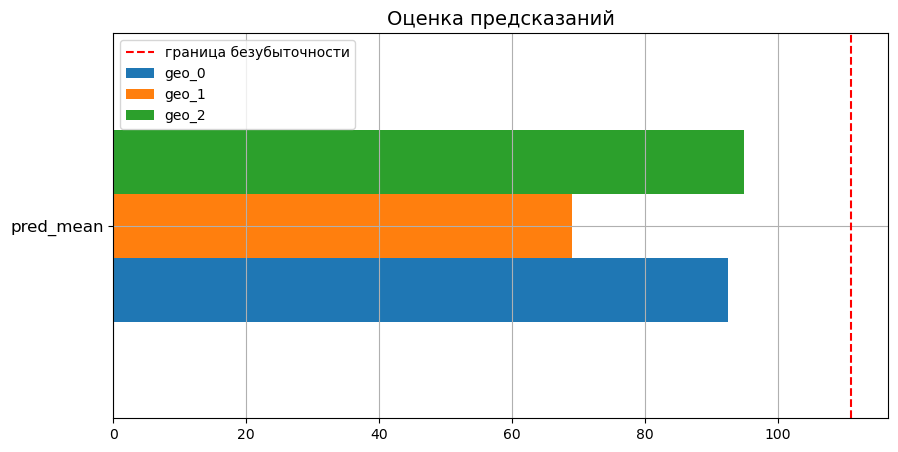

In [21]:
#построим график
score.drop(['rmse','target_mean']).plot(kind='barh',grid=True, figsize=(10, 5))
plt.axvline(INCOME_ONE_WELL, color='red',ls='--', lw=1.5, label='граница безубыточности')
plt.title('Оценка предсказаний',fontsize=14)
plt.yticks(fontsize=12, rotation=0)
plt.legend(title='', loc=2)
plt.show();

In [22]:
#функция для расчета прибыли для региона(200 лучших скважин)
def revenue(target, probabilities, count):
    target = target.reset_index(drop=True)
    probabilities = probabilities.reset_index(drop=True)
    
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return (INCOME_ONE_BARREL * selected.sum()) - BUDGET

In [23]:
print('Доход для региона geo_0 млн.р: ', int(revenue(target_answers['geo_0'],pred_answers['geo_0'], BEST_WELLS)))
print('Доход для региона geo_1 млн.р: ', int(revenue(target_answers['geo_1'],pred_answers['geo_1'], BEST_WELLS)))
print('Доход для региона geo_2 млн.р: ', int(revenue(target_answers['geo_2'],pred_answers['geo_2'], BEST_WELLS)))

Доход для региона geo_0 млн.р:  3260781417
Доход для региона geo_1 млн.р:  2415086696
Доход для региона geo_2 млн.р:  2563093352


**Вывод:**
<a id='income'></a>
1. Доход для региона geo_0: 3.260.781.417 млрд.р
2. Доход для региона geo_1: 2.415.086.696 млрд.р
3. Доход для региона geo_2: 2.563.093.352 млрд.р
- По итогам самый доходный регион это geo_0
- Решение:
- Так как будет выбрано для разработки 200 лучших скважин, сначала мы нашли цену одной скважины, далее мы нашли сколько баррелей содержится в цене одной скважины, чтобы понять какой объем она должна иметь, чтобы работать в 0, далее мы написали функцию для расчета прибыли, которая принимает на вход целевое значение таблицы, предсказанный ответ и кол-во элементов, далее мы отбираем(сортируем по убыванию) 200 самых больших значений, потому что по условию задачи у нас 200 лучших скважин, далее по вероятностным индексам отбираем из целевого признака 200 самых больших значений, чтобы понять какой доход был бы на самом деле после предсказания модели, т.е индексы от предсказания модели а значения настоящие по этим индесам, далее мы складываем значения и умножаем на доход с 1 барреля и вычитаем бюджет чтобы понять возможную прибыль
---

# 4. Расчёт прибыли и рисков

- Для метода bootstrap напишем функцию, которая принимает целевой ответ и предсказание. 999 раз мы разбиваем целевой признак по 500 элементов и считаем доход с помощью функции revenue(), которая отбирает 200 самых доходных скважин для каждого региона, считаем для каждого региона считаем 2.5% квантиль то есть мы как бы расчитываем если бы доход был в 2.5% то на какое число мы бы примерно получили, далее находим среднюю прибыль, проценнт риска это доля отрицательных доходов во всех, и строим доверительный интервал, то есть с вероятностью 95% истинное среднее всей генеральной совокупности находится в данном интервале

In [24]:
def start(target,prediction):
    target = target.reset_index(drop=True)
    prediction = prediction.reset_index(drop=True)
    values = []
    low = 0
    state = np.random.RandomState(11)
    for i in range(1000):                 
        target_subsample = target.sample(n=NUMBER_OF_WELLS, replace=True, random_state=state)
        probs_subsample = prediction[target_subsample.index]
        values.append(revenue(target_subsample, probs_subsample, BEST_WELLS))
        if values[i]<0:
            low+=1
        
    values = pd.Series(values)
    print('2.5% квантиль:',round(values.quantile(0.025),1))
    print('Средняя прибыль:',round(values.mean(),1))
    print('Процент риска:',low/len(values)*100,'%')
    print('95% Доверительный интервал:',(round(values.quantile(0.025),1), round(values.quantile(0.975),1)))

In [25]:
#смотрим на регион geo_0
start(target_answers['geo_0'],pred_answers['geo_0'])

2.5% квантиль: -76846107.5
Средняя прибыль: 425085686.3
Процент риска: 4.3999999999999995 %
95% Доверительный интервал: (-76846107.5, 908108249.3)


In [26]:
#смотрим на регион geo_1
start(target_answers['geo_1'],pred_answers['geo_1'])

2.5% квантиль: 62449537.6
Средняя прибыль: 475169688.5
Процент риска: 0.8999999999999999 %
95% Доверительный интервал: (62449537.6, 851605255.7)


In [27]:
#смотрим на регион geo_2
start(target_answers['geo_2'],pred_answers['geo_2'])

2.5% квантиль: -113036119.5
Средняя прибыль: 392743810.6
Процент риска: 7.5 %
95% Доверительный интервал: (-113036119.5, 921617929.5)


**Вывод:**
<a id='mean'></a>
<a id='risk'></a>
- По возрастанию уровня риска: 
1. geo_1: 0.89 %
2. geo_0: 4.3 %
3. geo_2: 7.5 %
- По средней прибыли:
1. geo_1: 475.169.688 млн.р
2. geo_0: 425.085.686 млн.р
3. geo_2: 392.743.810 млн.р
- Исходя из условий задачи, только регион geo_1 подходит т.к уровень риска не превышает допустимые 2.5%, но регион geo_1 я не могу рекомендовать т.к в целевом признаке не естественное распределение значений
- Можно посмотреть в сторону geo_0, так как там больше средняя прибыль и процент риска меньше чем в регионе geo_2

### Общий вывод:
- [Мы изучили данные](#start), посмотрели распределения признаков, [обучили модель](#study) и сделали предсказания для каждого региона

**geo_0:**
- Доход для региона geo_0: 2.415.086.696 млрд.р
- Уровень риска:  4.3 %
- Средняя прибыль: 475.169.688 млн.р

**geo_1:**
- Доход для региона geo_0: 3.260.781.417 млрд.р
- Уровень риска:  0.89 %
- Средняя прибыль: 425.085.686 млн.р

**geo_2:**
- Доход для региона geo_0: 2.563.093.352 млрд.р
- Уровень риска:  7.5 %
- Средняя прибыль: 392.743.810 млн.р


**При выборе региона предлагаю остановиться на geo_1**, потому что:
- Мы с помощью процедуры bootstrap мы можно сказать провели 999 исследований региона, мы сделали 999 выборок, а как мы знаем благодаря Центральной предельной теореме, чем больше выборку берем тем ближе выборочное среднее к истинному среднему всей генеральной совокупности. Далее в числах: 
  - [Ошибка](#error) в предсказаниях у geo_1 самая низкая 
  - [Доход](#income) для региона: 3.260.781.417 млрд.р
  - [Средняя прибыль](#mean): 475.169.688 млн.р
  - [Процент риска](#risk) менее 1 процента = 0.89%

****

# Чек-лист готовности
- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован